In [1]:
#pip install segysak

In [35]:
# Libraries for computation 
import numpy as np
from joblib import Parallel, delayed
import os
from numpy import sum
import time
import pandas as pd
import collections

# Libraries for plotting and interfaces
import tqdm.auto
import matplotlib
import matplotlib.pyplot as plt

# Library for loading segy files
import segysak
from segysak import segy
from segysak.segy import segy_loader, segy_header_scrape

In [36]:
class Semblance:
    
    """This class of Semblance consist of various steps, like looking for the various headers , loading the segy files, visualizing shots,
       cmp sorting and visualizing it, calculation of semblance panels and visualizing it."""

    path = "D:/germany/seismic.segy"  # path of segy file

    def __init__(self, header=None):
        if header!=None:
            self.header = header

    def text_header(self):
        """
        Input : 
            path : str
                takes path of segy file as input

        Returns:
            text_header : text headrs
        """        
        return segy.get_segy_texthead(Semblance.path)

    def bin_scrap(self):
        """
        Input : 
            path : str
                takes path of segy file as input

        Returns:
            values in bin : dict
                            In the form of dictonary 
        """
        return segy.segy_bin_scrape(Semblance.path)

    def header_scan(self):
        """
        Input : 
            path : str
                takes path of segy file as input

        Returns:
            header_values_byte_locations : DataFrame 
                                           header values byte locations in pandas DataFrame
        """
        return segy.segy_header_scan(Semblance.path)

    def header_scrap(self):
        """
        Input : 
            path : str
                takes path of segy file as input

        Returns:
            header values  : DataFrame
                             header values in pandas DataFrame
        """
        return segy_header_scrape(Semblance.path)

    def get_header_values(self):
        """
        Input : 
            header name : str
                        which header info  you want

        Returns:
            header values : np.ndarray 
                            ndarray of header value
        """
        return Semblance.header_scrap(self)[self.header].to_numpy()

    def loader(self):
        """
        Input : 
            path : str
                takes path of segy file as input

        Returns:
            gather : xarray
                     Contain all data and information in the form of xarray 
        """
        return segy_loader(Semblance.path, vert_domain='TWT')

    @staticmethod
    def shot_plotter(shot_gather : np.ndarray, shot_no : int, offset_traces : np.ndarray, trace_number : np.ndarray, times: np.ndarray):
        """
        Input : 
            shot_gather : np.ndarray
                        Contain all the traces corresponding to the shots in increasing order.
            
            shot_no :  int
                    Shot number which you want to plot
            
            offset_traces : np.ndarray
                            array containing offsets of all the traces
            
            trace_number : np.ndarray
                        array containing tracl no. of all the traces
            
            times : np.ndarray
                    array containing recording time of the shots

        Returns:
            plot : plt
                     Plot of a shot with resperct to tracl and offsets
        """
        
        
        nrcv = 120
        trace_number = trace_number - 1
        if shot_no == 1:
            shot = shot_gather[:, :nrcv]
            tr_no0 = trace_number[0]
            tr_no1 = trace_number[nrcv-1]
            off_tr0 = offset_traces[0]
            off_tr1 = offset_traces[nrcv-1]
        else:
            shot = shot_gather[:, (shot_no - 1)*nrcv:shot_no*nrcv]
            tr_no0 = trace_number[nrcv*(shot_no - 1)]
            tr_no1 = trace_number[nrcv*shot_no - 1]
            off_tr0 = offset_traces[nrcv*(shot_no - 1)]
            off_tr1 = offset_traces[nrcv*shot_no - 1]
        
        fig = plt.figure(figsize=(15, 8))
        
        vmin, vmax = np.percentile(shot, [15, 85])

        ax = plt.subplot(121)

        ax.set_title(f'for Shot = {shot_no}',fontsize=13)
        ax.set_xlabel('trace number',fontsize=15)
        ax.set_ylabel('time (sec) ',fontsize=15)
        ax.imshow(shot, extent=[tr_no0, tr_no1, times[-1], 0],
          aspect='auto', cmap='Greys', vmin=vmin, vmax=vmax)

        ax = plt.subplot(122)
        ax.set_title(f'for Shot = {shot_no}',fontsize=13)
        ax.set_xlabel('offsets (m) ',fontsize=15)
        ax.set_ylabel('time (sec) ',fontsize=15)
        ax.imshow(shot, extent=[off_tr0, off_tr1, times[-1], 0],
          aspect='auto', cmap='Greys', vmin=vmin, vmax=vmax)

        plt.show()

    @staticmethod
    def cdp_trace(traces : np.ndarray, cdp_traces : np.ndarray, cdp_no : int) -> np.ndarray :
        """
        Input : 
            traces : np.ndarray
                    array containing tracl no. of all the traces
            
            cdp_traces : np.ndarray
                        array containing cdp no. of all the traces
                        
            cdp_no: int
                    unique cdp no. corresponding to which you want trace numbers

        Returns:
            cdp_traces : np.ndarray
                        Contain cdp_trace no. corresponding to the unique cdp no.
        """
        return traces[cdp_traces==cdp_no]

    @staticmethod
    def cdp_offset(offset_traces : np.ndarray, cdp_traces : np.ndarray, cdp_no : int) -> np.ndarray :
        """
        Input : 
            offset_traces : np.ndarray
                    array containing offsets of all the traces
            
            cdp_traces : np.ndarray
                        array containing cdp no. of all the traces
                        
            cdp_no: int
                    unique cdp no. corresponding to which you want trace numbers

        Returns:
            cdp_offset : np.ndarray
                        Contain cdp_offset's corresponding to the unique cdp no.
        """
        return offset_traces[cdp_traces==cdp_no]

    @staticmethod
    def cdp_sort(shot_gather : np.ndarray, cdp_trace : np.ndarray) -> np.ndarray :
        """
        Input : 
            shot_gather : np.ndarray
                    array containing offsets of all the traces
            
            cdp_traces : np.ndarray
                        array containing tracl no's. for a unique cdp no.
                        
        Returns:
            cdp_gather : np.ndarray
                        Contain cdp_gather corresponding to the unique cdp no. for which the tracl no. are the cdp_traces
        """
        return shot_gather[:,cdp_trace]

    @staticmethod
    def cdp_plotter(cdp : np.ndarray, cdp_traces : np.ndarray, cdp_offsets : np.ndarray, cdp_no : int, times : np.ndarray):
        """
        Input : 
            cdp : np.ndarray
                  Contain cdp gather for a unique cdp.
            
            cdp_traces :  np.ndarray
                          array containing tracl no's. for a unique cdp no.
            
            cdp_offsets : np.ndarray
                          Contain cdp_offset's corresponding to the unique cdp no.
            
            cdp_no : int
                     unique cdp no. corresponding to which you want trace numbers
            
            times : np.ndarray
                    array containing recording time of the shots

        Returns:
            plot : plt
                     Plot of a cdp gather with resperct to tracl and offsets
        """
        
        fig = plt.figure(figsize=(15, 8))
        vmin, vmax = np.percentile(cdp, [15, 85])

        ax = plt.subplot(121)

        ax.set_title(f'CMP {cdp_no}',fontsize=30)
        ax.set_xlabel('trace number',fontsize=20)
        ax.set_ylabel('time (sec)' ,fontsize=20)
        ax.imshow(cdp, extent=[cdp_traces[0], cdp_traces[-1], times[-1], 0],
                  aspect='auto', cmap='Greys', vmin=vmin, vmax=vmax)
        
        ax = plt.subplot(122)
        ax.set_title(f'CMP {cdp_no}',fontsize=30)
        ax.set_xlabel('offsets (m) ',fontsize=20)
        ax.set_ylabel('time (sec) ',fontsize=20)
        ax.imshow(cdp, extent=[cdp_offsets[0], cdp_offsets[-1], times[-1], 0],
                  aspect='auto', cmap='Greys', vmin=vmin, vmax=vmax)
        plt.show()

    @staticmethod
    def velocity(min_vel : int, max_vel : int, interval : int) -> np.ndarray :
        """
        Input : 
            min_vel : int
                      minimum value of the velocity you want
            
            max_vel : int
                      maximum value of the velocity you want
                        
            interval : int
                       step in velocity array you want

        Returns:
            velocity : np.ndarray
                       Velocity array containg the velocity
        """
        return np.arange(min_vel, max_vel, interval)

    @staticmethod
    def reflection_time(time : float, offset : np.ndarray, velocity : float) -> np.ndarray :
        """
        Input : 
            time : float
                   zeor-offset time 
            
            offset : np.ndarray
                     array of offset's
                        
            velocity : float
                       a value of velocity 

        Returns:
            reflection_time : np.ndarray
                              array containg the reflection time corresponding to a time, velocity and array of offset's
        """
        t = np.sqrt(time**2 + offset**2/velocity**2)
        return t

    @staticmethod
    def interpolate_amplitude(cmp : np.ndarray, trajectory : np.ndarray, sample_rate : float) -> np.ndarray :
        """
        Input : 
            cmp : np.ndarray
                cdp gather for a unique cdp
            
            trajectory : np.ndarray
                        reflection time corresponding to a time, velocity and array of offset's
                        
            sample_rate : float
                        sampling interval

        Returns:
            interpolated_amplitude : np.ndarray
                                    array containg the amplitude's at reflection time (trajectory)
        """  

        amp = np.zeros(len(trajectory))
        n_samples, n_traces = cmp.shape
        dt = sample_rate

        time = trajectory/dt

        traj = time.astype('i')

        mask = (traj < n_samples - 1 ) & ( traj >= 0 )

        t_before = traj
        t_after = t_before + 1
        ntr = np.arange(n_traces)

        amp0 = cmp[t_before[mask], ntr[mask]]
        amp1 = cmp[t_after[mask], ntr[mask]]

        interp = (amp0 * (time - t_after)[mask])/ ((t_before - t_after)[mask]) + (amp1 * (time - t_before)[mask]) / ((t_after - t_before)[mask])

        return interp

    @staticmethod
    def semblance_IA(cmp : np.ndarray, times : np.ndarray, offsets : np.ndarray, velocities : np.ndarray, window : int,
                     sample_rate : float) -> np.ndarray :
        """
        Input : 
            cmp : np.ndarray
                  Contain cdp gather for a unique cdp.
                  
            times : np.ndarray
                    array containing recording time of the shots
                    
            offsets : np.ndarray
                      Contain cdp_offset's corresponding to the unique cdp no.
                          
            velocities : np.ndarray
                         Velocity array containg the velocity
            
            window : int
                     sample window or time window length over which you want to compute semblance
                     
            sample_rate : float
                          sampling interval
            
        Returns:
            semblance : np.ndarray
                        Contain semblance corresponding to the cdp gather.
        """

        n_samples, n_traces = cmp.shape
        semb = np.zeros((len(times), len(velocities)))
        l1 = np.arange(-window//2, 0)
        l2 = np.arange(0, window//2)
        ntr = np.arange(60)

        ncpu = 4 #os.cpu_count()
        time_batch = np.array_split(times, ncpu)
        
        res = Parallel(n_jobs=-1)(delayed(Semblance._process)(
        time_batch[i], velocities, offsets, cmp, sample_rate, n_samples, 
        l1, l2, ntr) for i in range(ncpu))

        return np.concatenate(res)

    @staticmethod
    def _process(time_batch : np.ndarray, velocities : np.ndarray, offsets : np.ndarray, cmp : np.ndarray, sample_rate :float,
                 n_samples : int, l1 : np.ndarray, l2 : np.ndarray, ntr : np.ndarray):
        """
        Input :
            time_batch : np.ndarray
                         a batch of time which we get by splitting the times array into batches
                         
            velocities : np.ndarray
                         Velocity array containg the velocity
            
            offsets : np.ndarray
                      Contain cdp_offset's corresponding to the unique cdp no.
            
            cmp : np.ndarray
                  Contain cdp gather for a unique cdp.
                     
            sample_rate : float
                          sampling interval
                          
            n_samples : int
                        no. of samples in a trace
                        
            l1 : np.ndarray
                 array containing upper window range
                 
            l2 : np.ndarray
                 array containing lower window range
            
            ntr : np.ndarray
                  array containing trace no's. in a cdp gather
            
        Returns:
            semblance_batch : np.ndarray
                              Contain semblance_batch corresponding to the cdp gather and time_batch.
        """
        semb = np.zeros((len(time_batch), len(velocities)))
        for n, time in enumerate(time_batch):
            for q, velocity in enumerate(velocities):

                trajectory = Semblance.reflection_time(time, offsets, velocity)

                amp = Semblance.interpolate_amplitude(cmp, trajectory, sample_rate)

                l = np.round(trajectory / sample_rate).astype('i')

                win1 = (l[:, None] + l1).T.astype('i')
                win2 = (l[:, None] + l2).T.astype('i')

                win11 = np.logical_and(win1 >= 0, win1 < n_samples)
                win22 = np.logical_and(win2 >= 0, win2 < n_samples)

                amp1 = np.zeros(win11.shape)

                amp2 = np.zeros(win22.shape)

                for i, w in enumerate(win11):
                        amp1[i, :sum(w)] = cmp[win1[i, w], ntr[w]]
                        
                for i, w in enumerate(win22):
                        amp2[i, :sum(w)] = cmp[win2[i, w], ntr[w]]
                
                num = sum(sum(amp1, axis=1)**2) + sum(amp)**2 + sum(sum(amp2, axis=1)**2)
                den = sum(sum(amp1**2, axis=1)*sum(win11, axis=1)) + sum(amp**2)*len(amp) + sum(sum(amp2**2, axis=1)*sum(win22, axis=1))
                
                semb[n,q] = num/(den) # + 1e-10)
                
        return semb

    @staticmethod
    def semblance_plotter(semblance : np.ndarray, cdp_no : np.integer, window : int):
        """
        Input : 
            semblance : np.ndarray
                        Contain semblance corresponding to the cdp gather.
            
            cdp_no : int
                     unique cdp no. corresponding to which semblance is calculated
            
            window : int
                     sample window or time window length over which the semblance is calculated

        Returns:
            plot : plt
                     Plot of a semblance (velocity panel) for a cdp gather
        """

        fig = plt.figure(figsize=(5, 7))

        plt.title(f'Semblance for cdp={cdp_no}, window={window}', fontsize=13)
        plt.xlabel('Velocity (m/sec) ',fontsize=15)
        plt.ylabel('Time (sec) ',fontsize=15)
        aspect = 'auto'
        clip=0.9
        img = plt.imshow(semblance, extent=[1200, 3600, 5.996, 0],
          aspect=aspect, cmap='jet', vmin=0, vmax=clip*np.max(semblance))
        plt.colorbar(img, label="semblance",shrink=0.5, ax=plt.gca())
  
        plt.show()

In [5]:
Semblance.path = "D:/germany/seismic.segy"

In [6]:
Semblance.path

'D:/germany/seismic.segy'

In [7]:
text_header = Semblance().text_header()
text_header

Text HeaderC 1 CLIENT                        COMPANY                       CREW NO
C 2 LINE            AREA                        MAP ID
C 3 REEL NO           DAY-START OF REEL     YEAR      OBSERVER
C 4 INSTRUMENT: MFG            MODEL            SERIAL NO
C 5 DATA TRACES/RECORD        AUXILIARY TRACES/RECORD         CDP FOLD
C 6 SAMPLE INTERNAL         SAMPLES/TRACE       BITS/IN      BYTES/SAMPLE
C 7 RECORDING FORMAT        FORMAT THIS REEL        MEASUREMENT SYSTEM
C 8 SAMPLE CODE: FLOATING PT     FIXED PT     FIXED PT-GAIN     CORRELATED
C 9 GAIN  TYPE: FIXED     BINARY     FLOATING POINT     OTHER
C10 FILTERS: ALIAS     HZ  NOTCH     HZ  BAND    -     HZ  SLOPE    -    DB/OCT
C11 SOURCE: TYPE            NUMBER/POINT        POINT INTERVAL
C12     PATTERN:                           LENGTH        WIDTH
C13 SWEEP: START     HZ  END     HZ  LENGTH      MS  CHANNEL NO     TYPE
C14 TAPER: START LENGTH       MS  END LENGTH       MS  TYPE
C15 SPREAD: OFFSET        MAX DISTANCE        GROUP INTERVAL
C16 GEOPHONES: PER GROUP     SPACING     FREQUENCY     MFG          MODEL
C17     PATTERN:                           LENGTH        WIDTH
C18 TRACES SORTED BY: RECORD     CDP     OTHER
C19 AMPLITUDE RECOVEY: NONE      SPHERICAL DIV       AGC    OTHER
C20 MAP PROJECTION                      ZONE ID       COORDINATE UNITS
C21 PROCESSING:
C22 PROCESSING:
C23
C24
C25
C26
C27
C28
C29
C30
C31
C32
C33
C34
C35
C36
C37
C38
C39
C40 END EBCDIC

In [8]:
biin = Semblance().bin_scrap()
biin

{'JobID': 9999,
 'LineNumber': 9999,
 'ReelNumber': 1,
 'Traces': 120,
 'AuxTraces': 0,
 'Interval': 4000,
 'IntervalOriginal': 4000,
 'Samples': 1500,
 'SamplesOriginal': 1500,
 'Format': 1,
 'EnsembleFold': 0,
 'SortingCode': 1,
 'VerticalSum': 1,
 'SweepFrequencyStart': 0,
 'SweepFrequencyEnd': 0,
 'SweepLength': 0,
 'Sweep': 0,
 'SweepChannel': 0,
 'SweepTaperStart': 0,
 'SweepTaperEnd': 0,
 'Taper': 0,
 'CorrelatedTraces': 2,
 'BinaryGainRecovery': 1,
 'AmplitudeRecovery': 4,
 'MeasurementSystem': 1,
 'ImpulseSignalPolarity': 1,
 'VibratoryPolarity': 0,
 'ExtTraces': 0,
 'ExtAuxTraces': 0,
 'ExtSamples': 0,
 'ExtSamplesOriginal': 0,
 'ExtEnsembleFold': 0,
 'SEGYRevision': 0,
 'SEGYRevisionMinor': 0,
 'TraceFlag': 0,
 'ExtendedHeaders': 0}

In [9]:
header_scan = Semblance().header_scan()
header_scan

  0%|          | 0.00/1.00k [00:00<?, ? traces/s]

,byte_loc,count,mean,std,min,25%,50%,75%,max
TRACE_SEQUENCE_LINE,1,1000.0,500.50,288.819436,1.0,250.75,500.5,750.25,1000.0
TRACE_SEQUENCE_FILE,5,1000.0,500.50,288.819436,1.0,250.75,500.5,750.25,1000.0
FieldRecord,9,1000.0,6.68,2.413177,3.0,5.00,7.0,9.00,11.0
TraceNumber,13,1000.0,58.90,34.927209,1.0,28.00,58.0,89.00,120.0
EnergySourcePoint,17,1000.0,104.68,2.413177,101.0,103.00,105.0,107.00,109.0
...,...,...,...,...,...,...,...,...,...
SourceEnergyDirectionMantissa,219,1000.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0
SourceEnergyDirectionExponent,223,1000.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementMantissa,225,1000.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementExponent,229,1000.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0


In [10]:
header_scrap = Semblance().header_scrap()
header_scrap

  0%|          | 0.00/120k [00:00<?, ? traces/s]

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,TransductionConstantPower,TransductionUnit,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit
0,1,1,3,1,101,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,2,3,2,101,2,2,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,3,3,3,101,3,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,4,3,4,101,4,4,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,5,3,5,101,5,5,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120115,120116,120116,1003,116,1112,2138,116,1,0,1,...,0,0,0,0,0,0,0,0,0,0
120116,120117,120117,1003,117,1112,2139,117,1,0,1,...,0,0,0,0,0,0,0,0,0,0
120117,120118,120118,1003,118,1112,2140,118,1,0,1,...,0,0,0,0,0,0,0,0,0,0
120118,120119,120119,1003,119,1112,2141,119,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
headers = Semblance().header_scrap().columns
headers

  0%|          | 0.00/120k [00:00<?, ? traces/s]

Index(['TRACE_SEQUENCE_LINE', 'TRACE_SEQUENCE_FILE', 'FieldRecord',
       'TraceNumber', 'EnergySourcePoint', 'CDP', 'CDP_TRACE',
       'TraceIdentificationCode', 'NSummedTraces', 'NStackedTraces', 'DataUse',
       'offset', 'ReceiverGroupElevation', 'SourceSurfaceElevation',
       'SourceDepth', 'ReceiverDatumElevation', 'SourceDatumElevation',
       'SourceWaterDepth', 'GroupWaterDepth', 'ElevationScalar',
       'SourceGroupScalar', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'CoordinateUnits', 'WeatheringVelocity', 'SubWeatheringVelocity',
       'SourceUpholeTime', 'GroupUpholeTime', 'SourceStaticCorrection',
       'GroupStaticCorrection', 'TotalStaticApplied', 'LagTimeA', 'LagTimeB',
       'DelayRecordingTime', 'MuteTimeStart', 'MuteTimeEND',
       'TRACE_SAMPLE_COUNT', 'TRACE_SAMPLE_INTERVAL', 'GainType',
       'InstrumentGainConstant', 'InstrumentInitialGain', 'Correlated',
       'SweepFrequencyStart', 'SweepFrequencyEnd', 'SweepLength', 'SweepType',
       'Swee

In [12]:
np.argwhere(headers == "CDP")

array([[5]], dtype=int64)

In [13]:
traces = Semblance(headers[0]).get_header_values()
traces

  0%|          | 0.00/120k [00:00<?, ? traces/s]

array([     1,      2,      3, ..., 120118, 120119, 120120], dtype=uint32)

In [14]:
offset_traces = Semblance(headers[11]).get_header_values()
offset_traces

  0%|          | 0.00/120k [00:00<?, ? traces/s]

array([-3237, -3212, -3187, ...,  -312,  -287,  -262], dtype=int64)

In [15]:
cdp_traces = Semblance(headers[5]).get_header_values()
cdp_traces

  0%|          | 0.00/120k [00:00<?, ? traces/s]

array([   1,    2,    3, ..., 2140, 2141, 2142], dtype=uint16)

In [16]:
cdp_no = np.unique(cdp_traces)
offsets = np.unique(offset_traces)
cdp_no, offsets

(array([   1,    2,    3, ..., 2140, 2141, 2142], dtype=uint16),
 array([-3237, -3212, -3187, -3162, -3137, -3112, -3087, -3062, -3037,
        -3012, -2987, -2962, -2937, -2912, -2887, -2862, -2837, -2812,
        -2787, -2762, -2737, -2712, -2687, -2662, -2637, -2612, -2587,
        -2562, -2537, -2512, -2487, -2462, -2437, -2412, -2387, -2362,
        -2337, -2312, -2287, -2262, -2237, -2212, -2187, -2162, -2137,
        -2112, -2087, -2062, -2037, -2012, -1987, -1962, -1937, -1912,
        -1887, -1862, -1837, -1812, -1787, -1762, -1737, -1712, -1687,
        -1662, -1637, -1612, -1587, -1562, -1537, -1512, -1487, -1462,
        -1437, -1412, -1387, -1362, -1337, -1312, -1287, -1262, -1237,
        -1212, -1187, -1162, -1137, -1112, -1087, -1062, -1037, -1012,
         -987,  -962,  -937,  -912,  -887,  -862,  -837,  -812,  -787,
         -762,  -737,  -712,  -687,  -662,  -637,  -612,  -587,  -562,
         -537,  -512,  -487,  -462,  -437,  -412,  -387,  -362,  -337,
         -31

In [17]:
freq = collections.Counter(cdp_traces).most_common()

In [18]:
freq[0]

(119, 60)

In [19]:
fold = []
for i in cdp_no:
  for j in freq:
    if i == j[0]:
      fold.append(j[1])
fold = np.asarray(fold)

In [20]:
fold

array([1, 1, 2, ..., 2, 1, 1])

In [21]:
dict = { "cdp_no" : cdp_no,
          "fold"   : fold }
df = pd.DataFrame(dict)
df

,cdp_no,fold
0,1,1
1,2,1
2,3,2
3,4,2
4,5,3
...,...,...
2137,2138,3
2138,2139,2
2139,2140,2
2140,2141,1


In [22]:
gather = Semblance().loader()

  0%|          | 0.00/120k [00:00<?, ? traces/s]

                     byte_loc     count          mean           std     min   
TRACE_SEQUENCE_LINE         1  120120.0  60060.500000  34675.801505     1.0  \
TRACE_SEQUENCE_FILE         5  120120.0  60060.500000  34675.801505     1.0   
FieldRecord                 9  120120.0    503.000000    288.964868     3.0   
TraceNumber                13  120120.0     60.500000     34.639958     1.0   
EnergySourcePoint          17  120120.0    608.011988    291.880762   101.0   
CDP                        21  120120.0   1074.523976    584.788376     1.0   
CDP_TRACE                  25  120120.0     60.500000     34.639958     1.0   
offset                     37  120120.0  -1749.500000    865.998938 -3237.0   
SourceX                    73  120120.0  15912.299700   7297.019059  3237.0   
GroupX                     81  120120.0  14162.799700   7348.227086     0.0   

                          25%      50%       75%       max  unique  
TRACE_SEQUENCE_LINE  30030.75  60060.5  90090.25  120120.0  1

Converting SEGY:   0%|          | 0.00/120k [00:00<?, ? traces/s]

In [23]:
gather

<xarray.Dataset>
Dimensions:  (cdp: 120120, twt: 1500)
Coordinates:
  * cdp      (cdp) int64 0 1 2 3 4 5 ... 120115 120116 120117 120118 120119
  * twt      (twt) float64 0.0 4.0 8.0 12.0 ... 5.988e+03 5.992e+03 5.996e+03
Data variables:
    data     (cdp, twt) float32 0.02719 -0.2826 0.2906 ... 1.199 0.7039 0.1119
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C 1 CLIENT                        COMPANY           ...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         seismic.segy
    srd:                 None
    datatype:            None
    percentiles:         [-1204.46607533928, -708.5978158883606, -21.27948380...
    coord_scalar:        1.0

In [24]:
shot_gather = gather.data.data.T
shot_gather.shape

(1500, 120120)

In [25]:
times = gather.data.twt.values*10**-3 # in seconds
n_samples = biin['Samples'] # no. of samples
dt = gather.attrs['sample_rate']*10**-3 # seconds

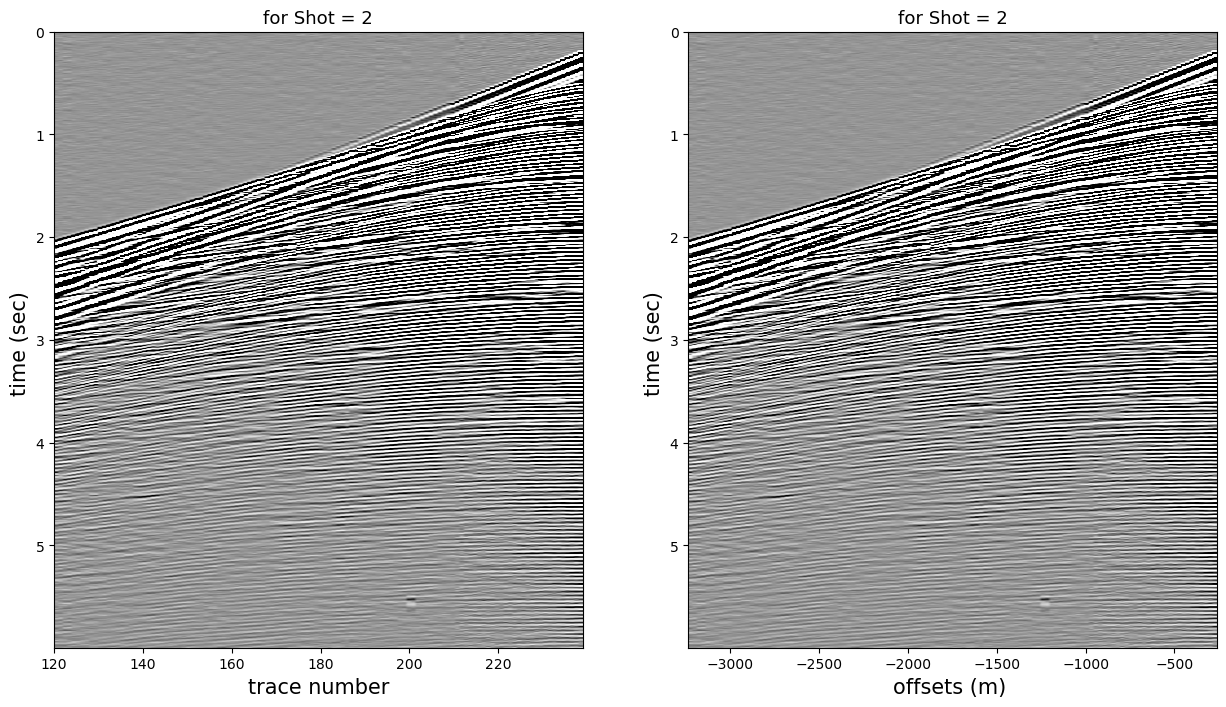

In [26]:
Semblance.shot_plotter(shot_gather, 2, offset_traces, traces, times)

In [27]:
cdps = []
cdps_tr = []
cdps_off = []

for cdp in cdp_no:
    tr = Semblance.cdp_trace(traces-1, cdp_traces-1, cdp-1)
    off = Semblance.cdp_offset(offset_traces, cdp_traces-1, cdp-1)
    cdps_tr.append(tr)
    cdps_off.append(off)
    cdps.append(Semblance.cdp_sort(shot_gather, tr))

In [28]:
k = 450  # cdp_no - 1
cdps[k], cdps_tr[k], cdps_off[k]

(array([[ 0.3002138 , -0.18918705,  0.16801453, ..., -0.39700603,
          0.18612957, -0.06015778],
        [-0.0774498 , -0.19428635,  0.49758816, ..., -0.43197536,
          0.13204098,  0.11113167],
        [-0.5933542 ,  0.14841652, -0.67721367, ...,  0.08058929,
          0.12439156, -0.2622528 ],
        ...,
        [ 0.76809597,  0.5681467 ,  0.6143303 , ...,  1.1191235 ,
         -0.08787727,  0.4997425 ],
        [ 0.4252844 ,  1.404623  ,  1.5896759 , ...,  0.80076694,
          0.6405802 , -0.01693916],
        [-0.2728958 ,  0.48001766,  0.5975065 , ..., -0.03726673,
          0.1673193 , -0.40557766]], dtype=float32),
 array([19438, 19556, 19674, 19792, 19910, 20028, 20146, 20264, 20382,
        20500, 20618, 20736, 20854, 20972, 21090, 21208, 21326, 21444,
        21562, 21680, 21798, 21916, 22034, 22152, 22270, 22388, 22506,
        22624, 22742, 22860, 22978, 23096, 23214, 23332, 23450, 23568,
        23686, 23804, 23922, 24040, 24158, 24276, 24394, 24512, 24630,
   

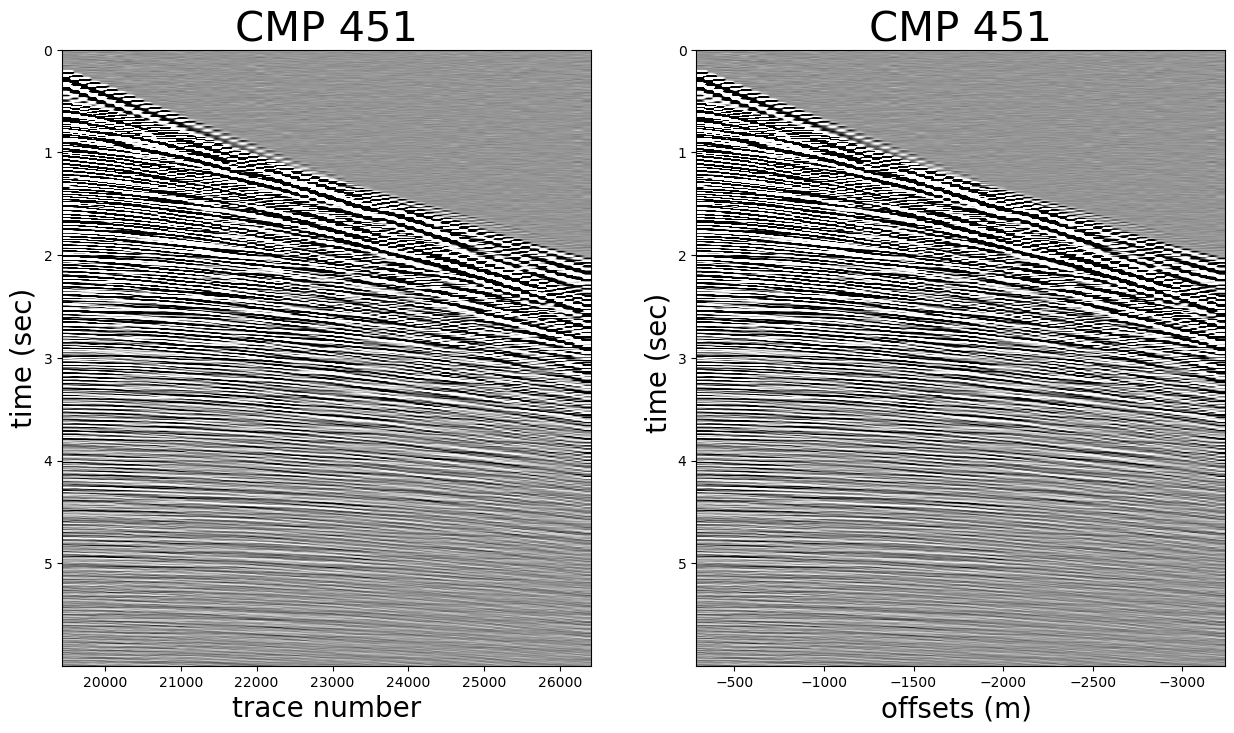

In [29]:
Semblance.cdp_plotter(cdps[k], cdps_tr[k], cdps_off[k], cdp_no[k], times)

In [30]:
velocity = Semblance.velocity(1200, 3600+10, 10)
velocity

array([1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300,
       1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410,
       1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520,
       1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630,
       1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740,
       1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 1850,
       1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960,
       1970, 1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070,
       2080, 2090, 2100, 2110, 2120, 2130, 2140, 2150, 2160, 2170, 2180,
       2190, 2200, 2210, 2220, 2230, 2240, 2250, 2260, 2270, 2280, 2290,
       2300, 2310, 2320, 2330, 2340, 2350, 2360, 2370, 2380, 2390, 2400,
       2410, 2420, 2430, 2440, 2450, 2460, 2470, 2480, 2490, 2500, 2510,
       2520, 2530, 2540, 2550, 2560, 2570, 2580, 2590, 2600, 2610, 2620,
       2630, 2640, 2650, 2660, 2670, 2680, 2690, 27

In [31]:
t1 = time.time()
sw = Semblance.semblance_IA(cdps[k], times, cdps_off[k], velocity, window=20, sample_rate=dt)
t2 = time.time()
t2 - t1

64.13159608840942

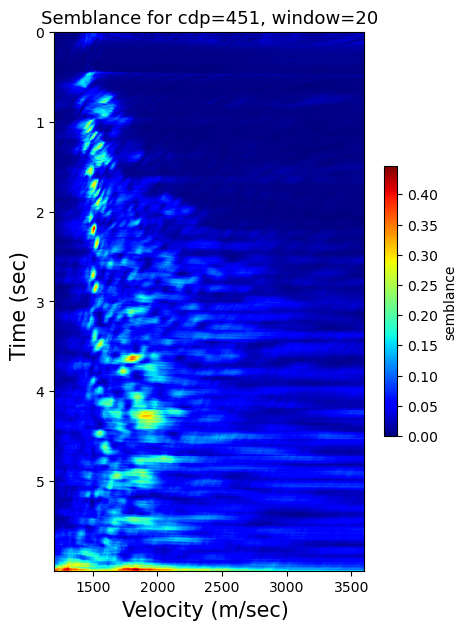

In [32]:
Semblance.semblance_plotter(sw, cdp_no[k], window=20)